# Demo Neural Collaborative Reasoning

In this demo, we will see how the NCR framework works. In particular, we will see:
1. important details about the framework that could be missed reading the [paper](https://arxiv.org/pdf/2005.08129.pdf).
2. how to train the NCR model on a selected dataset;
3. how to load and test the NCR model on a selected dataset; 

# Small introduction about NCR

Inspired by recent progress on neural-symbolic machine learning, the authors proposed neural collaborative reasoning (NCR), a framework to integrate the power of embedding learning and logical reasoning in the recommendation task. In fact, as a cognition rather than a perception task, recommendation requires not only the ability of pattern learning and matching, but also the ability of
cognitive reasoning, because a user’s future behavior may not be simply driven by its similarity with the user’s previous behaviors, but instead by the user’s cognitive reasoning procedure about what to do next. For example, if a user has purchased a laptop before, this does not lead to the user purchasing similar laptops in the future, rather, one would expect the user to purchase further equipment such as a laptop bag. Such a reasoning procedure may exhibit certain
logical structures, such as (a ∨ b) ∧ ¬c → v, which means that if the user likes a or b, and does not like c, then he/she would probability like v. As a representative cognitive reasoning task, an intelligent recommendation system should be able to discover and leverage the logical relations in data, so as to reason over the data for the prediction of user’s future behaviors. In order to achieve this goal, reasearchers proposed NCR, which defines the recommendation problem as a differentiable (i.e., neural) logical reasoning problem based on the wisdom of the crowd (i.e., collaborative). In particular, each user’s behavior record is considered as a logical implication rule, such as (a ∨ b) ∧ ¬c → v, meaning that the user liked item v given his/her previous preferences on a, b and c. In this sense, each user knows part of the whole logical space, so that it is possible to conduct collaborative logical reasoning based on the collective information from all users to estimate the preferences for new users. 

More specially, they proposed a Neural Logic Recommendation (NLR) framework based on Modularized Logical Neural Networks (MLNN), which integrates the power of embedding learning and logical reasoning in a shared architecture. The model learns each basic logical operation such as AND (∧), OR (∨), and NOT (¬) as a neural module based on logical regularizers. In this way, the recommendation problem can be formalized as estimating the probability that a future behavior v
is true given user’s previous behaviors, such as (a ∨ b) ∧ ¬c → v. Based on the definition of material implication (→), this reduces to the T/F evaluation of ¬((a ∨ b) ∧ ¬c) ∨ v, which only includes basic logical operations. As a result, the logical expression can be identically transformed into a neural architecture based on the logical neural modules, as shown in the figure below, which finally decides the T/F value of the expression. In this way, differentiable neural networks and symbolic reasoning are bridged in a shared
architecture for optimization and inference.

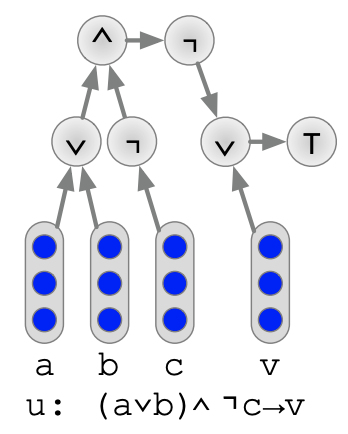



## The NCR workflow
1. dataset preprocessing and logical expressions construction;
2. NCR logical architecture and training;
3. NCR evaluation.

# Dataset preprocessing

In this work, the authors selected three datasets:
1. MovieLens 100k: a benchmark dataset containing ratings about movies;
2. Amazon Movies and TV: amazon dataset containing ratings about movies and TV;
3. Amazon Electronics: amazon dataset containing ratings about electronic items, such as smartphones, Ipads, and so on.

These datasets have been selected based on density and number of users and items. This selection allows to test the model performaces on three different settings that could occur while recommending items. It is possible to observe that with the increasing of the number of users and items, it increases the sparsity of the dataset too. So, the task becomes more challenging with the increasing of cardinality.

The following table contains the information about these datasets.

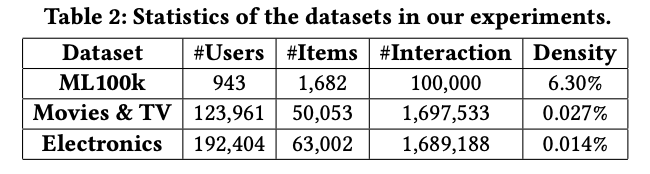

The dataset preprocessing is composed of the following important steps:
1. the ratings are transformed from the 1-5 scale to the 0-1 scale. Ratings equal to or higher than 4 are converted into a positive feedback (1), while ratings lower than 4 are covertend into a negative feedback (0). So, authors have assumed that with a rating of at least 4 we are sure that a user likes a particular item, while with a rating of 3 or less we are sure that a user dislikes a particular item. This is a strong assumption as ratings are subjective to users, but it makes sense in their recommendation setting. In fact, authors decided to use Propositional Logic to formalize the recommendation problem into a logical reasoning problem. Since propositional variables are boolean variables, we need to scale the ratings associated to the items in the 0-1 scale. In this way, a propositional variables x means "user u likes item x", while ¬x means "user u dislikes item x". Finally, it is important to note that the rating information is not filtered to reduce sparsity like it usually happens in other recommendation works. Instead, here all the rating information is kept to train the model.
2. The ratings are grouped by user and ordered by timestamp. We need to order the ratings by timestamp since we want to learn causal relationships in the user historical information. For example, we want to learn the fact that the purchase of a particular set of items in the past caused the purchase of a new specific item. In other words, we want to learn the logical reasoning process used by the user to decide what to buy based on his past purchase history. This logical reasoning process is formalized trough propositional logical expressions of the form of the expression mentioned before ((a ∨ b) ∧ ¬c → v).
3. For each user:
  - the first 5 positive ratings are kept in training set in order to reduce the cold-start problem. The cold-start problem occurs when the recommendation system has not enough positive feebacks to recommend new items to a particular user. This means it has not enough information to understand what the user likes and what it should recommend to him. This often happens when a new user is added to the system;
  - the last positive rating is hold out for the test set (leave-one-out);
  - the second to the last positive rating is hold out for the validation set.


Note that if the user has less than 5 positive rating, all the ratings are kept in training set. If the user has only 6 positive ratings, 5 are kept in training set and the last one is used for test set. If the user has more than 6 positive ratings, the procedure explained above is used.

4. For each user we build his train, validation, and test logical expressions. These logical expressions are then used to train and test the NCR model. Logical expressions are built as follows:
  - for each positive item in the user historical information, we select the 5 most recent items that come just before that specific item as the history set of the logical expression;
  - then, we build the logical expression using this template: (conjunction of items in the history set) -> selected positive item. 

Note that for the first ratings of a user historical information is not possible to have logical expressions with 5 items as premise. For example, if we have the history 1, 2, 3, 4, 5 and all these items are rated by the user as positive items, for item 2 we have only item 1 before, so a logical expression with 5 items as premise can not be built in this case. For this reason the authors decided to allow for premise of less than 5 items for these particular cases. So, for the history of the example we will have the following logical expressions:

  - 1 -> 2;
  - 1 ∧ 2 -> 3;
  - 1 ∧ 2 ∧ 3 -> 4;
  - 1 ∧ 2 ∧ 3 ∧ 4 -> 5.

Example of logical expression with 5 items as premise:
  
Let us assume we have the following history for a user u: 12, 34, 32, ¬4, 3, 7.
Here, we can use 12, 34, 32, ¬4, 3 as history set, and 7 as positive item that we want to predict the user rating on. So, we build the following expression: 12 ∧ 34 ∧ 32 ∧ ¬4 ∧ 3 -> 7. Here, 12 is a propositional variable for "the user u likes the item 12", while ¬4 is a propositional variable for "the user u dislikes the item 4". This formula encodes the logical reasoning process that we want to learn with NCR. In particular, we are interested in learning the fact that the purchase of 12, 34, 32, ¬4, 3 caused the purchase of 7.

# Understanding the NCR preprocessing by examples
This example is based on a real user from the MovieLens 100k dataset. The user has the following ratings in his historical information:

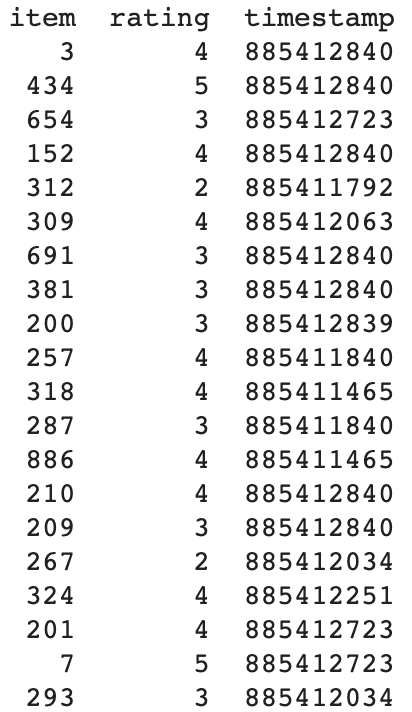


1. In the first step the user ratings are converted in 0-1 scale:


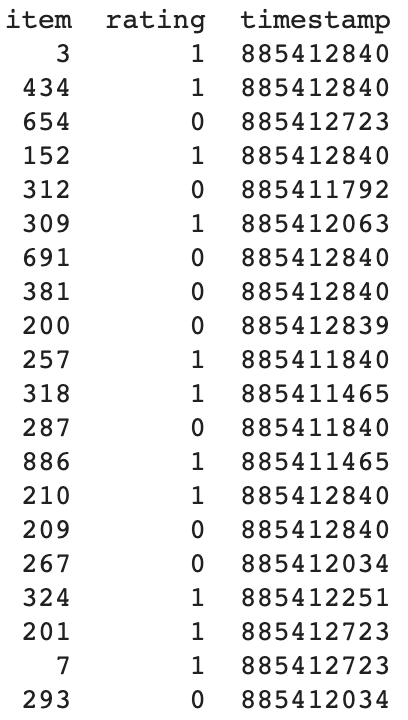

2. Then, we order the user ratings by timestamp:


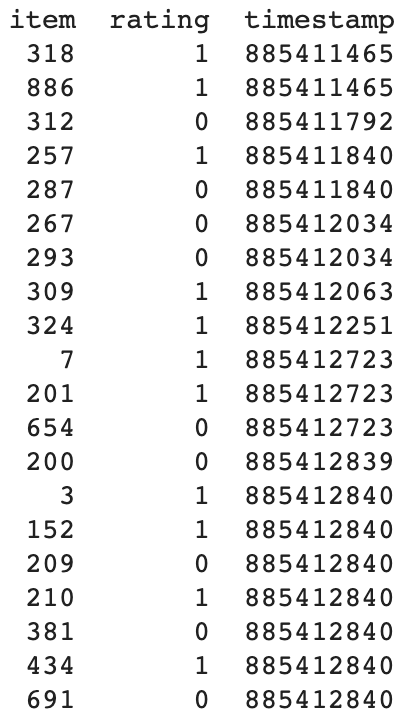

3. Now, we perform the train, validation, and test split. The splits are presented below.


Training set:

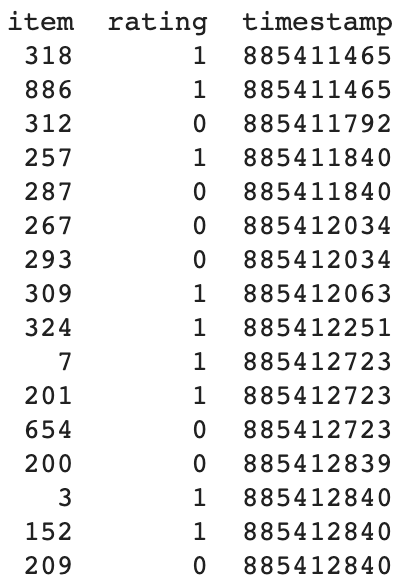


Validation set:


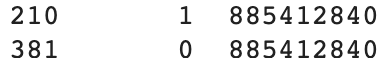



Test set:


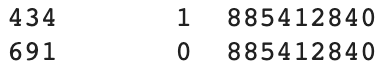

Note that the items with negative feedback in validation and test sets are not used as consequence in logical expressions. See the example below to understand which expressions are excactly constructed by the model.

4. Finally, we construct the logical expressions for the user:

Training logical expressions:

  - 318 -> 886
  - 318 ∧ 886 ∧ ¬312 -> 257
  - ¬312 ∧ 257 ∧ ¬287 ∧ ¬267 ∧ ¬293 -> 309
  - 257 ∧ ¬287 ∧ ¬267 ∧ ¬293 ∧ 309 -> 324
  - ¬287 ∧ ¬267 ∧ ¬293 ∧ 309 ∧ 324 -> 7
  - ¬267 ∧ ¬293 ∧ 309 ∧ 324 ∧ 7 -> 201
  - 324 ∧ 7 ∧ 201 ∧ ¬654 ∧ ¬200 -> 3
  - 7 ∧ 201 ∧ ¬654 ∧ ¬200 ∧ 3 -> 152

Validation logical expression: ¬654 ∧ ¬200 ∧ 3 ∧ 152 ∧ ¬209 -> 210

Test logical expression: 3 ∧ 152 ∧ ¬209 ∧ 210 ∧ ¬381 -> 434


# NCR logical architecture and training

The idea of NCR is to embbed logical expressions and logical propositional variables into a logical latent space and then to perform logical reasoning on that space in order to provide accurate recommendations based on logical reasoning. So, each propositional variable and logical expression has a vector representation which is learnt by NCR. Also, the logical latent space is regularized during training in order to be sure that the neural modules exibit the expected behavior.

How does this complex model work?  

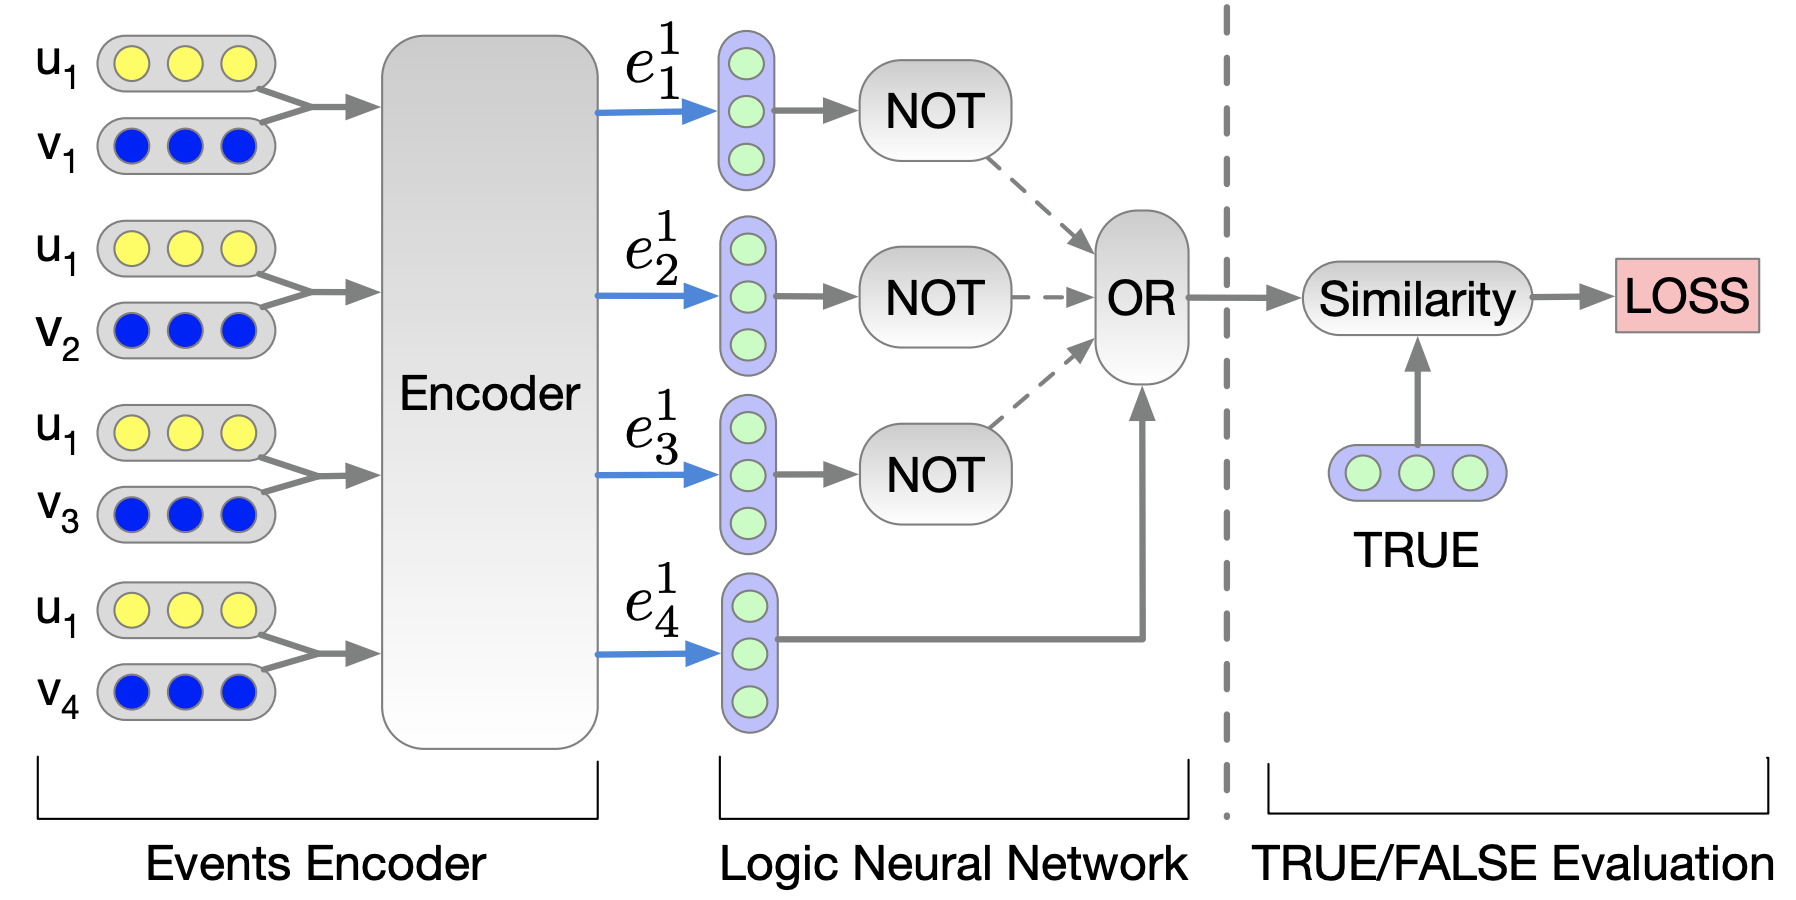

Let us assume we have the following history for user u: v1, v2, v3, v4.
For instance, we need to build the following logical expression: v1 ∧ v2 ∧ v3 -> v4. In order to get the latent representation for this logical expression, we have to feed it to the NCR network.
The NCR architecture is dynamic since it changes based on the given logical expression. For this specific example, the network takes as input the embedding of user u and the embeddings of items v1, v2, v3, v4, and constructs the logical expression: $\neg e^{u}_{1} \lor \neg e^{u}_{2} \lor \neg e^{u}_{3} \lor e^{u}_{4}$, where $e^{u}_{i}$ is a so-called event vector, a vector representation output by an encoder network which relate user u and item i. Note that this logical expression is equivalent to: $e^{u}_{1} \land e^{u}_{2} \land e^{u}_{3} \implies e^{u}_{4}$. De Morgan laws and material implication have been applied to get the final expression. Note that given the fact that the logical expressions contain only OR and NOT operators, we can learn only these two neural modules instead of learning the AND module too. Authors experimented that learning the minimal number of neural modules increases the model performances.

Specifically, in order to get the representation of the logical expression, an encoder is firstly used to relate the user embedding with the item embedding, obtaining the so-called event vector for the user-item pair. This process is done for each user-item pair.

After that, we use the computed event vectors for building the logical expression. In the architecture:
  - OR is a neural module that computes the logical OR operator of two input event vectors in the logical latent space. This module outputs a new event vector that is the result of the logical OR between the two input event vectors in the latent space;
  - NOT is similar to the OR module but it performs the logical negation of the input event vector in the logical latent space;
  - TRUE is a fixed latent vector that represents the TRUE logical constant. It is used as an anchor vector to learn the user and item embeddings;
  - Similarity is the cosine similarity between the event vector of the input logical expression and the TRUE vector. If the output is high it means that the item v4 can be recommended to user u, while if the output is low it means that the item v4 should not be recommended to user u.

How does the training work?

NCR uses the pair-wise learning procedure. In short, for each logical expression in the training set, we generate a negative logical expression. The negative logical expression is equal to the original expression but instead of having the target item at the right side of the implication, it has a randomly sampled item from the set of items that the user never interacted with. During training, we force the original (positive) logical expression to be as near as possible to the TRUE vector in the latent space, while we force the negative expression to be as far as possible from the TRUE vector in the latent space. This is achieved by minimising the following loss function through gradient descent:


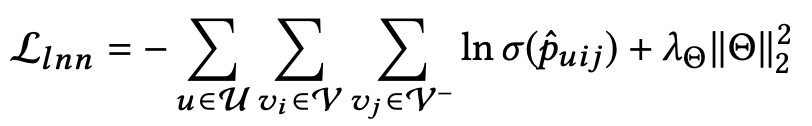

# Logical regularizers

During training, the NCR model adds an additional regularization term to the loss function reported above. This term is used to perform logical regularization over the logical latent space. Since it is not sure that the neural modules behave like the logical operators, these regularizers are used to force the modules to behave correctly, namely to let them work as exepected. For example, we want to be sure that the OR neural module returns an event vector that is the logical OR of the two input event vectors in the logical latent space. The logical regularizers are presented in the table below.

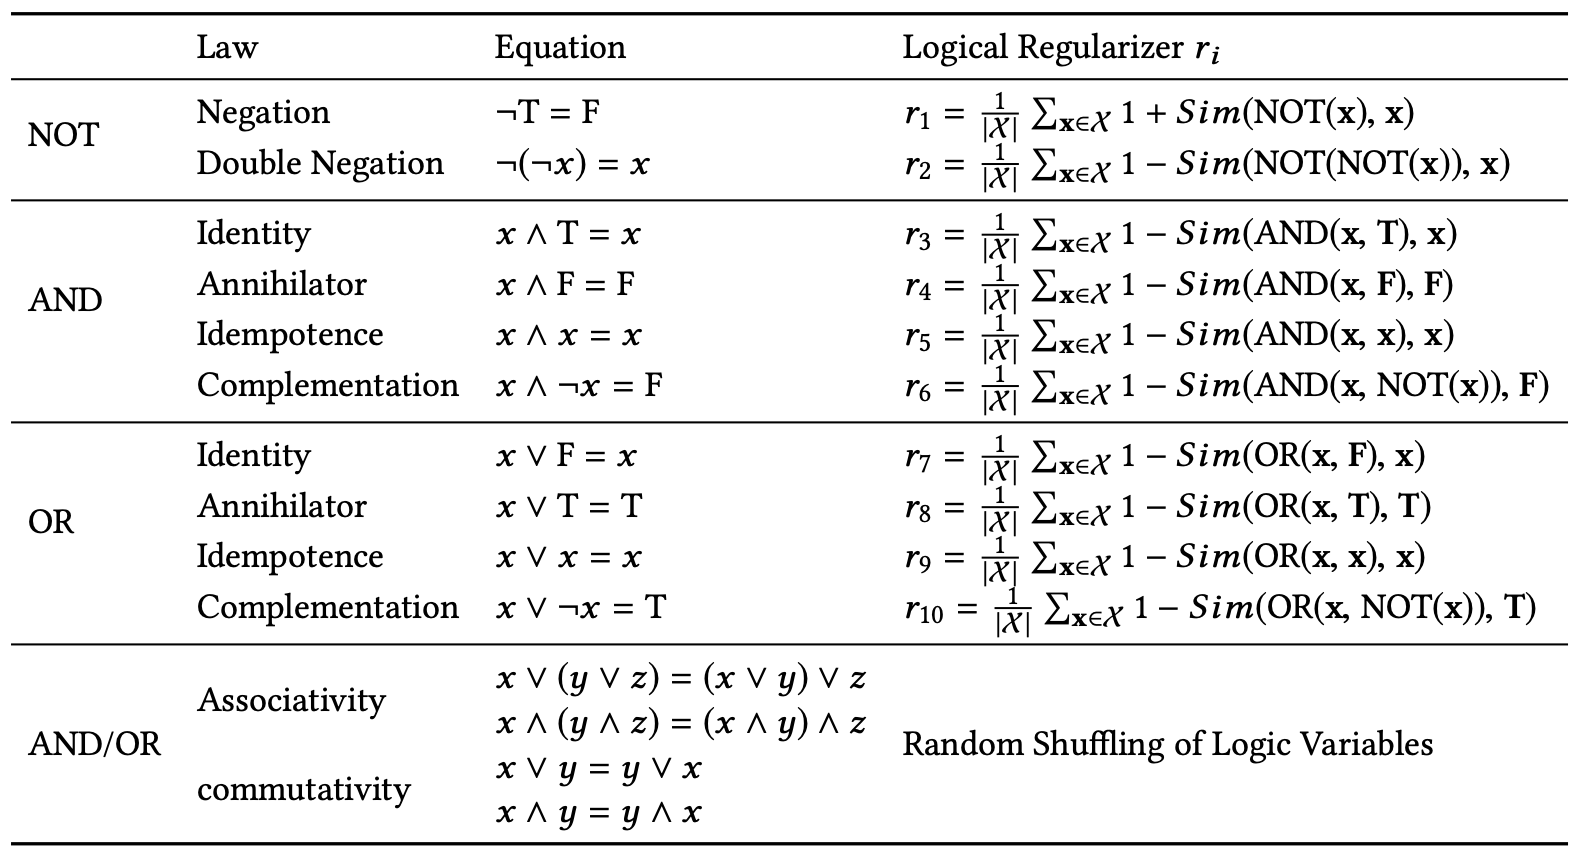

# NCR evaluation
The NCR model is validated and tested using the one-plus-random evaluation procedure. In short, for each logical expression in the test set, we randomly generate 100 negative logical expressions as explained previously. Then, we use the network to get the similarity between these 101 expressions and the TRUE vector in the logical latent space. Based on these similarities, we build a ranking of scores. Higher the similarity with the TRUE vector in the latent space, higher the position of the item in the ranking. After we have produced this ranking, we compute the test metrics based on the position of the target item against the position of the 100 negative items. This process is repeated for each logical expression in the test/validation set. After that, the results of these evaluations are averaged together.

# Code: training and testing the NCR framework on MovieLens 100k dataset

In [ ]:
!git clone https://github.com/bmxitalia/NCRProject.git

Cloning into 'NCRProject'...
remote: Enumerating objects: 236, done.
remote: Counting objects: 100% (236/236), done.
remote: Compressing objects: 100% (167/167), done.
remote: Total 236 (delta 132), reused 153 (delta 56), pack-reused 0
Receiving objects: 100% (236/236), 35.25 MiB | 20.65 MiB/s, done.
Resolving deltas: 100% (132/132), done.


In [ ]:
%cd NCRProject/

/content/NCRProject/NCRProject


In [ ]:
from ncr.data import Dataset
from ncr.samplers import DataSampler
from ncr.nets import NCR
from ncr.models import NCRTrainer
from ncr.evaluation import ValidFunc, logic_evaluate
import torch
import pandas as pd
import logging
logging.basicConfig()
logging.getLogger().setLevel(logging.DEBUG)

# select the faster device available for computation
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # set pytorch device for computation

def main():
    """
    This is the main() function which runs the experiments on the NCR framework. An experiment is made of the following
    steps:
        - preprocessing of the specified dataset with the specified parameters. This includes the split of the dataset
        into train, validation, and test folds;
        - construction of the NCR neural architecture with the specified parameters;
        - train of the NCR model with the specified training details and validation details;
        - test of the NCR model with the specified test metrics.
    """
    raw_dataset = pd.read_csv("datasets/movielens-100k/movielens_100k.csv")
    

    # create train, validation, and test sets
    dataset = Dataset(raw_dataset)
    dataset.process_data(threshold=4, order=True, leave_n=1, keep_n=5, max_history_length=5)
    
    # train loader
    train_loader = DataSampler(dataset.train_set, dataset.user_item_matrix, n_neg_samples=1,
                                batch_size=128, shuffle=True, seed=2022,
                                device=device)
    
    # validation loader
    val_loader = DataSampler(dataset.validation_set, dataset.user_item_matrix,
                              n_neg_samples=100, batch_size=128*2,
                              shuffle=False, seed=2022, device=device)

    # test loader
    test_loader = DataSampler(dataset.test_set, dataset.user_item_matrix, n_neg_samples=100,
                              batch_size=128*2, shuffle=False, seed=2022,
                              device=device)

    # NCR architecture
    ncr_net = NCR(dataset.n_users, dataset.n_items, emb_size=64, dropout=0.0,
                  seed=2022).to(device)

    # NCT trainer
    ncr_model = NCRTrainer(ncr_net, learning_rate=0.001, l2_weight=0.0001,
                           logic_reg_weight=0.1)

    # model training
    ncr_model.train(train_loader, valid_data=val_loader, valid_metric='ndcg@5',
                    valid_func=ValidFunc(logic_evaluate), num_epochs=100,
                    at_least=20, early_stop=5,
                    save_path="saved-models/best-ncr.json", verbose=1)

    # load best model found during training
    ncr_model.load_model("saved-models/best-ncr.json")

    # test the best model
    ncr_model.test(test_loader, test_metrics=['ndcg@5', 'ndcg@10', 'hit@5', 'hit@10'], n_times=10)

if __name__ == '__main__':
    main()

# Results obtained with my implementation

MovieLens 100k:
- ndcg@5: 0.374 (0.0130)
- ndcg@10: 0.426 (0.0119)
- hit@5: 0.526 (0.0163)
- hit@10: 0.689 (0.0152)

Amazon Movies and TV:
- ndcg@5: 0.415 (0.0017)
- ndcg@10: 0.457 (0.0015)
- hit@5: 0.550 (0.0020)
- hit@10: 0.680 (0.0019)

Amazon Electronics:
- ndcg@5: 0.336 (0.0014)
- ndcg@10: 0.375 (0.0013)
- hit@5: 0.452 (0.0017)
- hit@10: 0.574 (0.0017)

# Results obtained in the original paper

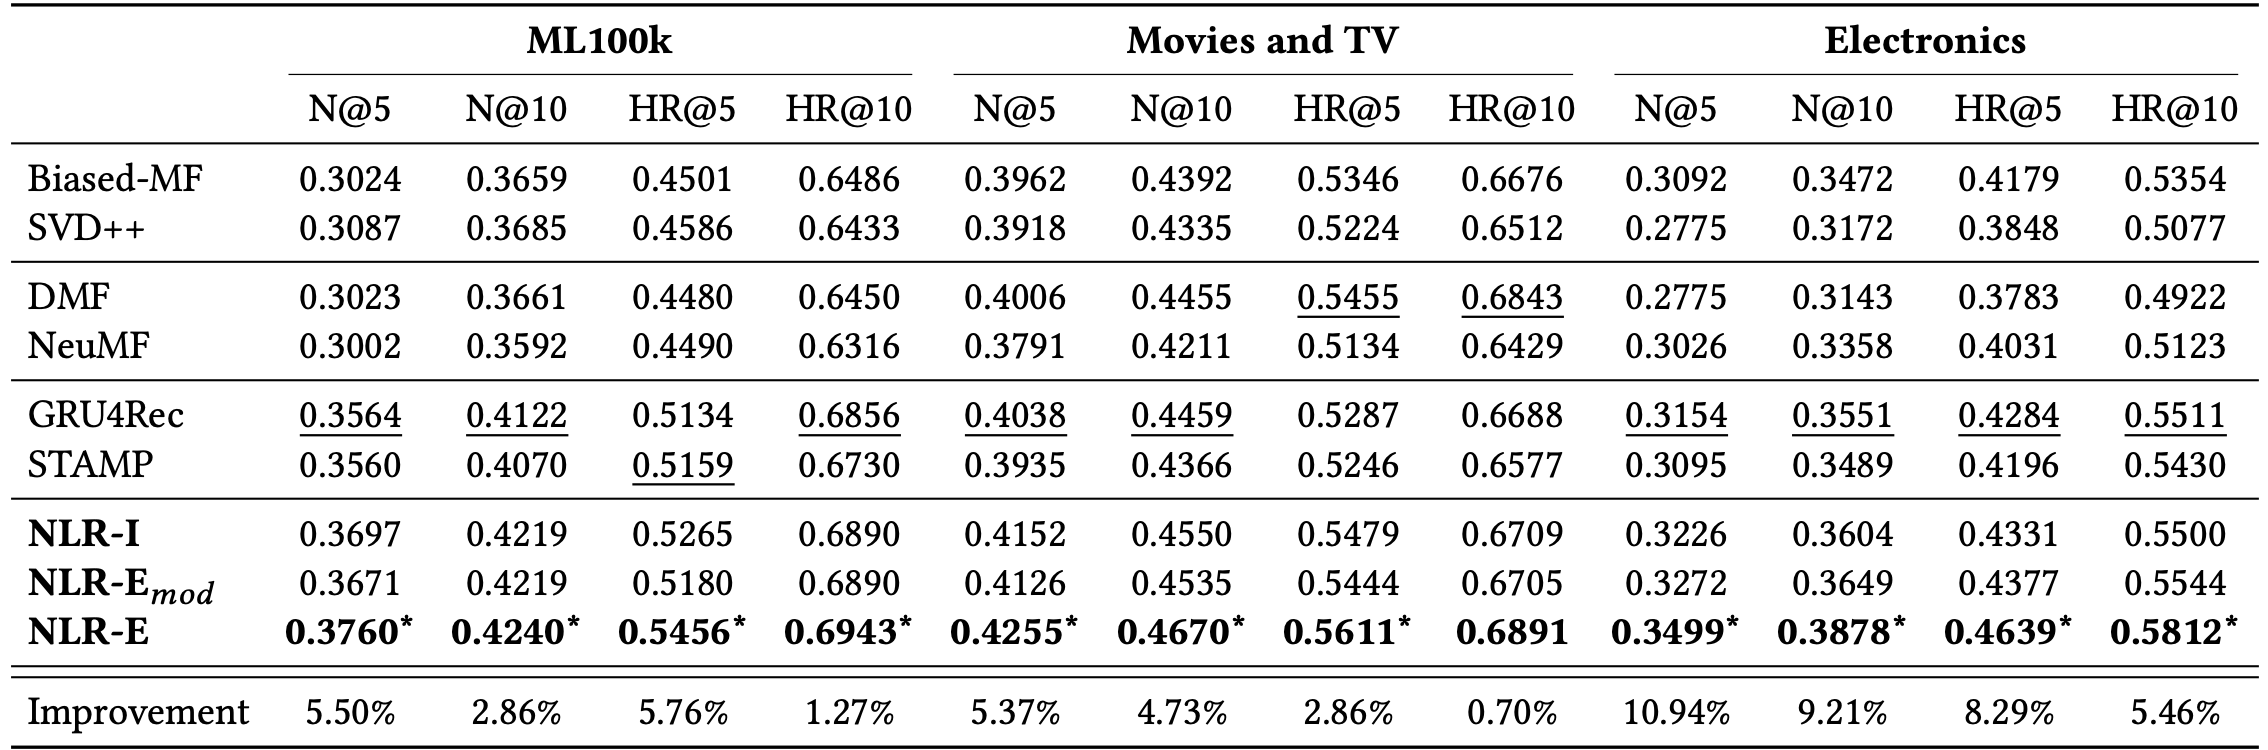